## **6. 군집화 실습 - 고객 세그먼테이션**

### **고객 세그먼테이션의 정의와 기법**

고객 세그먼테이션 (Customer Segmentation)
- 다양한 기준으로 고객을 분류하는 기법
- CRM이나 마케팅의 중요 기반 요소
- 주요 목표: 타깃 마케팅: 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것
- 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요 => 기본적인 고객 분석 요소인 RFM 기법 이용

RFM 기법
- Recency(R): 가장 최근 상품 구입 일에서 오늘까지의 시간
- Frequency(F): 상품 구매 횟수
- Monetary Value(M): 총 구매 금액

### **데이터 세트 로딩과 데이터 클렌징**

In [8]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df=pd.read_excel(r"C:\Users\이희원\OneDrive\바탕 화면\EWHA\4-1\ESAA\data\Online Retail.xlsx")
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [9]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- **Null 데이터 제거**: 특히 CustomerID가 Null인 데이터가 많음. 고객 세그먼테이션을 수행하므로 고객 식별 번호가 없는 데이터는 필요가 없기에 삭제.
- **오류 데이터 삭제**: 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우. 사실 Quantity가 0보다 작은 경우는 오류 데이터라기보다는 반환을 뜻하는 값. 이 경우 InvoiceNo 앞자리는 'C'로 되어있음. 분석의 효율성을 위해서 이 데이터는 모두 삭제.

- 불린 인덱싱을 적용해 Quantity > 0, UnitPrice > 0이고 CustomerID가 Not Null인 값만 다시 필터링

In [10]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- Country 칼럼은 주문 고객 국가. 주요 주문 고객은 영국인데 이 외에도 EU의 여러 나라와 영연방 국가들이 포함되어 있음. 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외.

In [11]:
retail_df['Country'].value_counts()

Country
United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [12]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### **RFM 기반 데이터 가공**

- 이제 사전 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행
- 먼저 UnitPrice와 Quantity를 곱해서 주문 금액 데이터 만들기
- CustomerNo도 더 편리한 식별성을 위해 float형을 int형으로 변경

In [13]:
retail_df['sale_amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

- 이 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 많은 특성을 가지고 있음.
- 개인 고객의 주문과 소매점의 주문이 함께 포함되어 있기 때문.
- Top-5 주문 건수와 주문 금액을 가진 고객 데이터를 추출해보자

In [14]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


- 몇몇 특정 고객이 많은 주문 건수와 주문 금액을 가지고 있음
- 주어진 온라인 판매 데이터 세트는 전형적인 판매 데이터 세트와 같이 주문번호(InvoiceNo) + 상품코드(StockCode) 레벨의 식별자로 되어 있음
- InvoiceNo + StockCode로 Groupby를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨을 알 수 있음

In [15]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

- 그런데 RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것
- 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경
- 이를 위해서는 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by 해야 함
- 주문번호 기준의 retail_df DataFrame에 groupby('CustomerID')를 적용해 CustomerID 기준으로 DataFrame을 새롭게 생성
- DataFrame의 groupby()만 사용해서는 여러 개의 칼럼에 서로 다른 aggregation 연산, 예를 들어 count()나 max()를 한 번에 수행하기 어려움
- 이를 해결하기 위해 DataFrame에 groupby를 호출해 반환된 DataFrameGroupby 객체에 agg()를 이용
- agg()에 인자로 대상 칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력하면 칼럼 여러 개의 서로 다른 aggregation 연산을 쉽게 수행 가능
- Frequency는 고객별 주문 건수이므로 CustomerID로 groupby()해서 InvoiceNo의 count() aggregation으로 구함
- Monetary value는 고객별 주문 금액이므로 CustomerID로 groupby()해서 sale_amount의 sum() aggregation으로 구함
- Recency는 최근 주문 일자이므로 CustomerID로 groupby()해서 InvoiceDate 칼럼의 max()로 고객별 가장 최근 주문 일자를 먼저 구한 뒤 추후에 가공 작업 별도 수행

In [21]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount': 'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recnecy, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


- Recency 칼럼은 개별 고객당 가장 최근의 주문인데, 데이터 값의 특성으로 인해 추가적인 데이터 가공 필요
- Recency는 고객이 가장 최근에 주문한 날짜를 기반으로 하는데, 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜임
- 주의할 점: 오늘 날짜를 현재 날짜로 해서는 안 됨
- 온라인 판매 데이터가 2010년 12월 1일에서 2011년 12월 9일까지의 데이터이므로 오늘 날짜는 2011년 12월 9일에서 하루 더한 2011년 12월 10일로 하자.
- 2011년 12월 10일을 현재 날짜로 간주하고 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성

In [22]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


- 이제 고객별로 RFM 분석에 필요한 Recency, Frequency, Monetary 칼럼을 모두 생성함
- 다음으로는 생성된 고객 RFM 데이터 세트의 특성을 개괄적으로 알아보고 RFM 기반에서 고객 세그먼테이션을 수행해보자

### **RFM 기반 고객 세그먼테이션**

- 온라인 판매 데이터 세트는 소매업체의 대규모 주문을 포함하고 있음
- 소매업체들은 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 나타내고 있음
- 따라서 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상 발생
- 먼저 온라인 판매 데이터 세트의 칼럼별 히스토그램을 확인하고, 이처럼 왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는지 알아보자.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

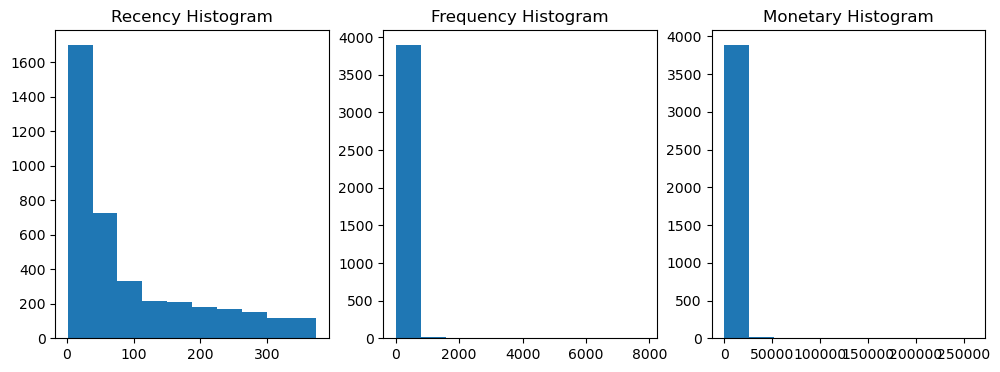

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

- Recency, Frequency, Monetary 모두 왜곡된 데이터 값 분포도를 가지고 있으며
- 특히 Frequency, Monetary의 경우 특정 범위에 값이 몰려 있어서 왜곡 정도가 매우 심함
- 각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포되어 있는지 확인하자

In [24]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


- 왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨
- 먼저 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균 수행

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features=cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.592


- 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적인 수치가 나옴
- 하지만 각 군집별 실루엣 계수 값은?

In [28]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [29]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

- 군집 개수를 2~5개까지 변화시키면서 개별 군집의 실루엣 계수 값과 데이터 구성을 함께 알아보자

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

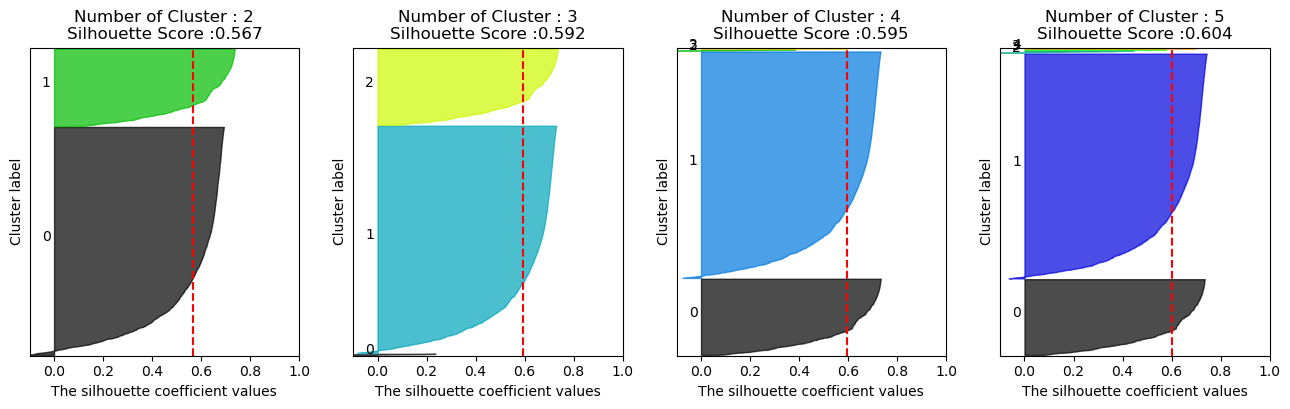

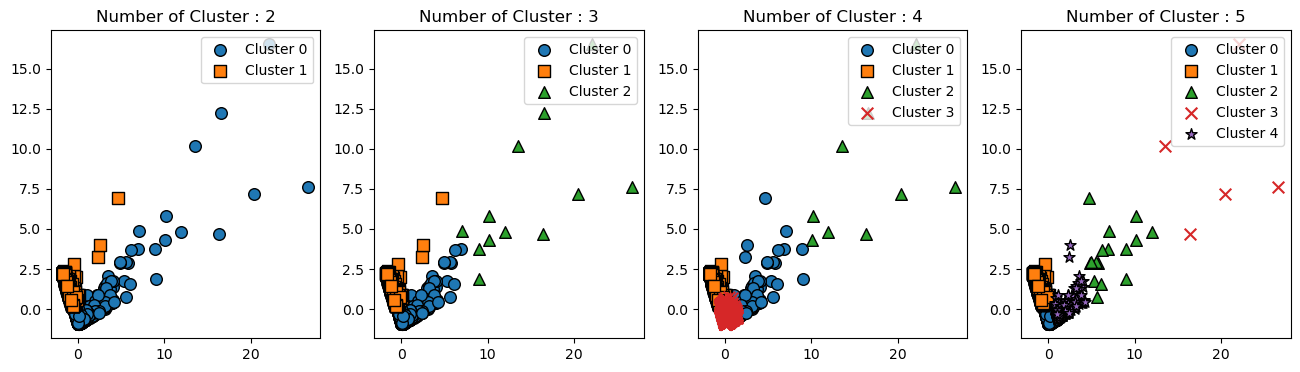

In [30]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

- 군집이 2개일 경우 0번 군집과 1번 군집이 너무 개괄적으로 군집화됨
- 군집 수를 증가시키면 개선이 가능할 것으로 예상되었는데, 실제 결과는 다름
- 군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어짐
- 이 군집에 속한 데이터는 개수가 작을뿐더러 실루엣 계수 역시 상대적으로 매우 작음
- 또한 군집 내부에서도 데이터가 광범위하게 퍼져 있음
- 군집이 3개일 때는 0번 군집의 데이터 건수가 매우 작고,
- 4개일 때는 2번, 3번 군집이
- 5개일 때는 2,3,4번 군집에 속한 데이터 세트의 개수가 너무 적고 광범위하게 퍼져 있음
- 이 소수의 데이터 세트는 앞에서 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터임
- 이 데이터 세트의 경우 데이터 값이 거리 기반으로 광범위하게 퍼져 있어서 군집 수를 계속 늘려봐야 이 군집만 지속적으로 분리하게 되기에 의미 없는 군집화가 됨

- 이러한 특이한 데이터 세트를 분리하고 도출하는 것이 군집화의 목표이기도 함
- 하지만 이 정도로 크게 왜곡된 데이터 세트의 도출은 굳이 군집화를 이용하지 않고도 간단한 데이터 분석만으로도 충분히 가능
- 이처럼 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출

- 비지도학습 알고리즘의 하나인 군집화의 기능적 의미는 숨어 있는 새로운 집단을 발견하는 것
- 새로운 군집 내의 데이터 값을 분석하고 이해함으로써 이 집단에 새로운 의미를 부여할 수 있음 => 전체 데이터를 다른 각도로 바라볼 수 있음

- 데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법: 데이터 값에 로그(Log)를 적용하는 로그 변환
- 온라인 판매 데이터 세트의 왜곡 정도를 낮추기 위해서 전체 데이터를 고르 변환한 뒤 K-평균 알고리즘을 적용하여 결과를 비교해보자.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log']=np.log1p(cust_df['Recency'])
cust_df['Frequency_log']=np.log1p(cust_df['Frequency'])
cust_df['Monetary_log']=np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features=cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled=StandardScaler().fit_transform(X_features)
kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.303


- 실루엣 스코어는 로그 변환하기 전보다 떨어짐
- 하지만 실루엣 스코어의 절대치가 중요한 것이 아님을 앞의 예제에서 알 수 있음
- 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요
- 로그 변환한 데이터 세트를 기반으로 실루엣 계수와 군집화 구성을 시각화해보자.

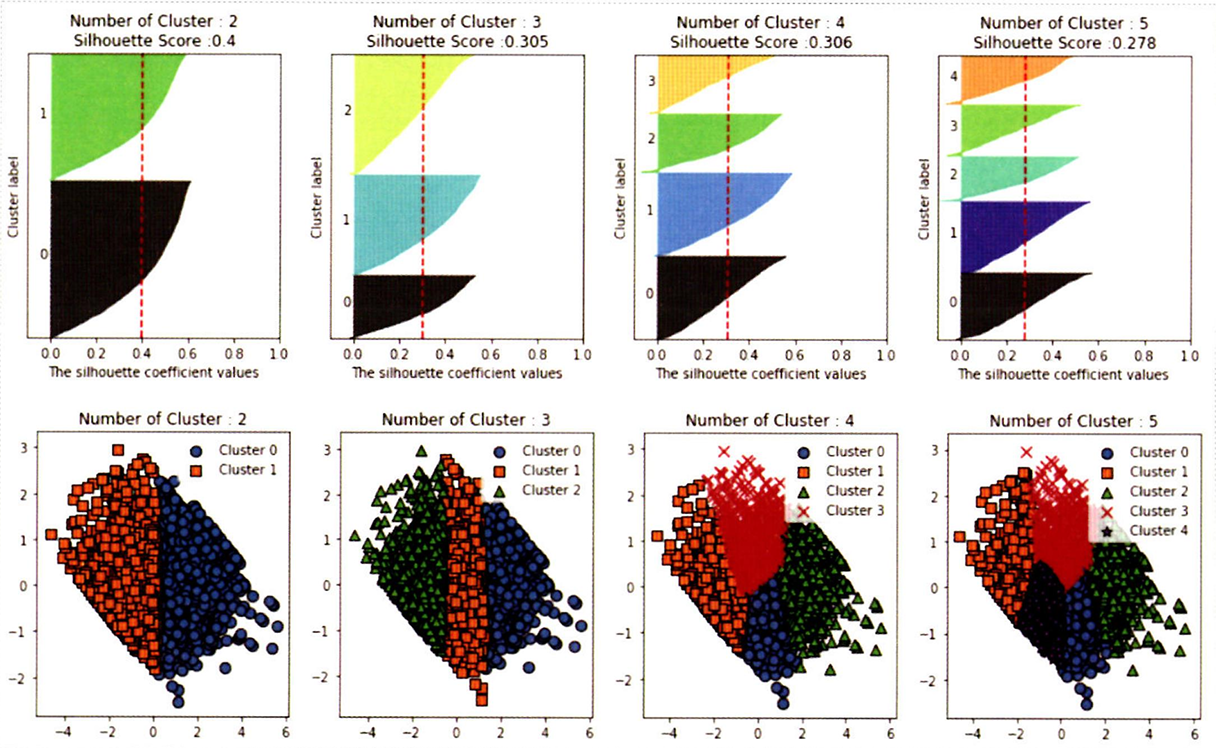

- 실루엣 스코어는 로그 변환하기 전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화가 구성되었음을 알 수 있음
- 이처럼 왜곡된 데이터 세트에 대해서는 로그 변환으로 데이터를 일차 변환한 후에 군집화를 수행하면 더 나은 결과 도출 가능

## **7. 정리**

- 각 군집화 기법은 장단점을 가지고 있으며, 군집화하려는 데이터의 특성에 맞게 선택해야 함
- K-평균
  - 거리 기반으로 군집 중심점을 이동시키면서 군집화 수행
  - 매우 쉽고 직관적인 알고리즘으로 많은 군집화 애플리케이션에 애용되지만, 복잡한 구조를 가지는 데이터 세트에 적용하기에 한계가 있음
  - 군집의 개수를 최적화하기 어려움
  - 군집이 잘 되었는지 평가하기 위해 실루엣 계수 이용
- 평균 이동(Mean Shift)
  - K-평균과 유사하지만 거리 중심이 아니라 데이터가 모여 있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화 수행
  - 일반 업무 기반의 정형 데이터 세트보다는 컴퓨터 비전 영역에서 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할 수행
- GMM(Gaussian Mixture Model)
  - 군집화를 적용하고자 하는 데이터를 여러 개의 가우시안 분포 모델을 섞어서 생성된 모델로 가정해 수행하는 방식
  - 전체 데이터 세트에서 서로 다른 정규 분포 형태를 추출해 이렇게 다른 정규 분포를 가진 데이터 세트를 각각 군집화
  - K-평균보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있다는 장점
  - 군집화를 위한 수행 시간이 오래 걸린다는 단점
- DBSCAN(Density Based Special Clustering of Applications with Noise)
  - 밀도 기반 군집화의 대표적인 알고리즘
  - 입실론 주변 영역 내에 포함되는 최소 데이터 개수의 충족 여부에 따라 데이터 포인트를 핵심 포인트, 이웃 포인트, 경계 포인트, 잡음 포인트로 구분하고 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화 구성
  - 간단하고 직관적인 알고리즘
  - 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화 가능